<a href="https://colab.research.google.com/github/lc2353/Houseplants-Recognition/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

find /Users/lucy/Documents/GitHub/Houseplants-Recognition -name ".DS_Store" -delete

In [35]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [67]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import shutil
import random

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.utils import np_utils
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16, preprocess_input
from PIL import Image

In [44]:
# Load the pre-trained VGG16 model with ImageNet weights
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Print the model summary
model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [42]:
# set up file paths and directories
data_path = '/content/drive/MyDrive/repos/Houseplant_Recognition/pothos_dataset'
train_data_path = os.path.join(data_path, 'training')
test_data_path = os.path.join(data_path, 'test')
model_path = '/content/drive/MyDrive/repos/Houseplant_Recognition/model.h5'

In [50]:
# Set the batch size and image size
batch_size = 32
image_size = (224, 224)
num_classes = 15

In [54]:
# Set the path to your data directory
data_dir = '/content/drive/MyDrive/repos/Houseplant_Recognition/pothos_images'

# Set the ratio of data to use for training, validation, and testing
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Create the directories for the split data
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop through each subdirectory in the data directory
for class_dir in os.listdir(data_dir):

    # Set the path to the class directory
    class_path = os.path.join(data_dir, class_dir)

    # Skip any non-directory files
    if not os.path.isdir(class_path):
        continue

    # Create the directories for this class in the train, validation, and test directories
    train_class_dir = os.path.join(train_dir, class_dir)
    val_class_dir = os.path.join(val_dir, class_dir)
    test_class_dir = os.path.join(test_dir, class_dir)

    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Loop through each image file in the class directory
    for file_name in os.listdir(class_path):

        # Set the path to the image file
        file_path = os.path.join(class_path, file_name)

        # Skip any non-image files
        if not file_name.endswith('.jpg'):
            continue

        # Decide which directory to use for this image
        rand_num = random.random()
        if rand_num < train_ratio:
            dest_dir = train_class_dir
        elif rand_num < train_ratio + val_ratio:
            dest_dir = val_class_dir
        else:
            dest_dir = test_class_dir

        # Copy the image file to the appropriate directory
        dest_path = os.path.join(dest_dir, file_name)
        shutil.copyfile(file_path, dest_path)


In [63]:
data_dir = '/content/drive/MyDrive/repos/Houseplant_Recognition/dataset'


# Create data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'val'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 289 images belonging to 15 classes.
Found 129 images belonging to 15 classes.
Found 90 images belonging to 15 classes.


In [71]:
# Create an instance of the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Add a custom output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add additional layers
x = base_model.output
x = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2), strides=(1,1))(x)
x = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2), strides=(1,1))(x)
x = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2), strides=(1,1))(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a categorical cross-entropy loss function and an Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

# Train the model using the data generators
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    verbose=1)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
10/10 [==============================] - 6s 496ms/step - loss: 2.8590 - accuracy: 0.0346 - val_loss: 2.7247 - val_accuracy: 0.0698
Epoch 2/100
10/10 [==============================] - 6s 592ms/step - loss: 2.7560 - accuracy: 0.0727 - val_loss: 2.7135 - val_accuracy: 0.0543
Epoch 3/100
10/10 [==============================] - 5s 468ms/step - loss: 2.7036 - accuracy: 0.0657 - val_loss: 2.6579 - val_accuracy: 0.1473
Epoch 4/100
10/10 [==============================] - 6s 601ms/step - loss: 2.6895 - accuracy: 0.0969 - val_loss: 2.6360 - val_accuracy: 0.1240
Epoch 5/100
10/10 [==============================] - 10s 1s/step - loss: 2.6715 - accuracy: 0.1038 - val_loss: 2.6479 - val_accuracy: 0.0698
Epoch 6/100
10/10 [==============================] - 5s 465ms/step - loss: 2.6540 - accuracy: 0.0796 - val_loss: 2.6148 - val_accuracy: 0.1163
Epoch 7/100
10/10 [==============================] - 5s 471ms/step - loss: 2.6445 - accuracy: 0.1003 - val_loss: 2.6091 - val_accuracy: 0.0775
E

In [74]:
model.save('/content/drive/MyDrive/repos/pothos-recognition.h5')

1/1 [==============================] - 0s 39ms/step
Baltic Blue Pothos: 100.00%
Cebu Blue Pothos: 0.00%
Glacier Pothos: 0.00%
Global Green Pothos: 0.00%
Golden Pothos: 0.00%
Harlequin Pothos: 0.00%
Jade Pothos: 0.00%
Jessenia Pothos: 0.00%
Manjula Pothos: 0.00%
Marble Queen Pothos: 0.00%
Neon Pothos: 0.00%
N’Joy Pothos: 0.00%
Pearls and Jade Pothos: 0.00%
Satin Pothos: 0.00%
Snow Queen Pothos: 0.00%


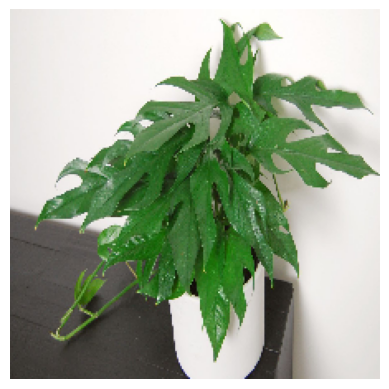

In [88]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Load the image and preprocess it
img_path = '/content/drive/MyDrive/repos/Houseplant_Recognition/how-to-grow-and-care-for-baltic-blue-pothos-6832821-hero-63f4a426632a45368d534b675471d698.jpg'
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make predictions on the image using the trained model
preds = model.predict(x)

# Get the class labels
class_labels = train_generator.class_indices
class_labels = dict((v,k) for k,v in class_labels.items())

# Display the image and predicted probabilities

plt.imshow(img)
plt.axis('off')

for i, val in enumerate(class_labels.values()):
    print("{}: {:0.2f}%".format(val, preds[0][i]*100))
